<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function should append to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function should also handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [3]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 19, subsample = 0.7, verbosity = 0) 

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)
    
    return xgb, ttimes


In [4]:
def train_classifier_DNN(X_train, y_train): 
    size = (10,) * 3
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='logistic',
                                solver='adam', learning_rate='invscaling', max_iter=1000)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)
    
    return dnn, ttimes


In [5]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=21, p=2, n_neighbors=4)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)
    
    return knn, ttimes

In [6]:
################################################################################################################
###### Split (X,y) obtained in task 3b (they had window length=10 and spacing=1) into train/test ######
###### sets (80%/20%). Then, call functions train_classifier_XGB() and train_classifier_DNN(). ########
###### Save trained models (returned by the three functions) into .json files. ########################
################################################################################################################'

lbl = [0, 1]

def training_alg(name, X_train, y_train, X_test, y_test):
    
    model, ttimes = None, []
    
    print(f'Training {name} 3 times...')
    if name == 'XGB':
        model, ttimes = train_classifier_XGB(X_train, y_train)
    elif name == 'MLP':
        model, ttimes = train_classifier_DNN(X_train, y_train)
    elif name == 'KNN':
        model, ttimes = train_classifier_KNN(X_train, y_train)
        
    # Added to fix: 'XGBClassifier' object has no attribute '_le'
    if (isinstance(model, XGBClassifier)):
        model._le = LabelEncoder().fit(y_test)
            
    y_pred = model.predict(X_test)
    
    accuracy = mt.accuracy_score(y_test, y_pred)
    global_precision = mt.precision_score(y_test, y_pred, labels=lbl, average='weighted')
    global_recall = mt.recall_score(y_test, y_pred, labels=lbl, average='weighted')
    global_f1score = mt.f1_score(y_test, y_pred, labels=lbl, average='weighted')
    
    y_score = model.predict_proba(X_test)[:, 1]
    
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test,  y_score)
    auc = roc_auc_score(y_test, y_score)
    
    stats = [ttimes, recall_curve, precision_curve, fpr, tpr, auc, accuracy, global_precision, global_recall, global_f1score]
    return stats

def training(X, y):
    # Stratify garantees the split all the scenarios among train and test
    # It's like shuffle and split
    # random_state it's a seed to get the same output
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    print(y_test)
    print(X_test)
    
    xgb_stats = training_alg('XGB', X_train, y_train, X_test, y_test)
    dnn_stats = training_alg('MLP', X_train, y_train, X_test, y_test)
    knn_stats = training_alg('KNN', X_train, y_train, X_test, y_test)
    
    return xgb_stats, dnn_stats, knn_stats


In [7]:
def load_dataset_path(folderpath, X, y, spacing, length):
    for filename in os.listdir(folderpath):
        #F: you should continue iterating over "Features" folder looking for the desired files    
        if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
            print(filename)
            label = 0
            if int(filename[9]) > 5:
              label = 1
            fullname = folderpath + '/' + filename
            X, y = load_window_dataset(X, y, fullname, label)
    return X, y

In [8]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X_raw=None 
y_raw=None
X_norm=None 
y_norm=None

#All scenario correlated ONLY TO "length=10" and "spacing=1"
length=10
spacing=1
folderpath_raw='../Features_raw'
folderpath_norm='../Features_norm'

print('Loading window dataset for RAW...')
X_raw, y_raw = load_dataset_path(folderpath_raw, X_raw, y_raw, spacing, length)

print('Loading window dataset for NORM...')
X_norm, y_norm = load_dataset_path(folderpath_norm, X_norm, y_norm, spacing, length)

X_raw = StandardScaler().fit_transform(X_raw)
X_norm = StandardScaler().fit_transform(X_norm)

xgb_stats_raw, dnn_stats_raw, knn_stats_raw = training(X_raw, y_raw)
xgb_stats_norm, dnn_stats_norm, knn_stats_norm = training(X_norm, y_norm)

Loading window dataset for RAW...
Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
Scenario_5_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_5_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
Scenario_5_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
Scenario_6_monitor_node_1_preamp_lpth_3-2_1_100GHz_sp1_w10.dat
Scenario_6_monitor_node_1_preamp_lpth_3-2_1_12.5GHz_sp1_w10.dat
Scenario_6_monitor_node_1_preamp_lpth_3-2_1_25GHz_sp1_w10.dat
Scenario_7_monitor_node_1_preamp_lpth_2_1_12.5GHz_sp1_w10.dat
Scenario_7_monitor_node_1_preamp_lpth_3-1_1_12.5GHz_s

In [9]:
def plot_roc_curve(fig_folder, alg_name, fpr_raw, tpr_raw, auc_raw, fpr_norm, tpr_norm, auc_norm):
    # create ROC curve
    fig, axs = plt.subplots(1, 2, figsize=(15,8))       
        
    axs[0].plot(fpr_raw,tpr_raw, color='purple',label="AUC="+str(auc_raw))
    axs[0].set_title(alg_name+' Raw ROC Curve')
    axs[0].legend(loc=4)
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].grid()
    
    axs[1].plot(fpr_norm,tpr_norm, color='purple',label="AUC="+str(auc_norm))
    axs[1].set_title(alg_name+' Normalized ROC Curve')
    axs[1].legend(loc=4)
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].grid()
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+alg_name+' Raw and Norm ROC Curve'.replace(" ", "_")+'.png')
    plt.show()
    
    
def plot_precision_recall_curve(fig_folder, alg_name, recall_curve_raw, precision_curve_raw, recall_curve_norm, precision_curve_norm):
    #create precision recall curve
    fig, axs = plt.subplots(1, 2, figsize=(15,8))  
    
    axs[0].plot(recall_curve_raw, precision_curve_raw, color='purple')
    #add axis labels to plot
    axs[0].set_title(alg_name+' Raw Precision-Recall Curve')
    axs[0].set_ylabel('Precision')
    axs[0].set_xlabel('Recall')
    axs[0].grid()
    
    axs[1].plot(recall_curve_norm, precision_curve_norm, color='purple')
    #add axis labels to plot
    axs[1].set_title(alg_name+' Normalized Precision-Recall Curve')
    axs[1].set_ylabel('Precision')
    axs[1].set_xlabel('Recall')
    axs[1].grid()
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+alg_name+' Raw and Norm Precision-Recall Curve'.replace(" ", "_")+'.png')
    plt.show()

def bar_chart_norm_impact(fig_folder, alg_name, labels, stats_norm, stats_raw):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,8))
    rects1 = ax.bar(x - width/2, stats_norm, width, label='Normalized')
    rects2 = ax.bar(x + width/2, stats_raw, width, label='Raw')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    image_title = alg_name+' OSNR Norm Impact on metrics'
    ax.set_title(image_title)
    ax.set_xticks(x, labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

    ax.bar_label(rects1, label_type='center', padding=3, rotation=45)
    ax.bar_label(rects2, label_type='center', padding=3, rotation=45)

    ax.grid()
    ax.set_axisbelow(True)
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')
    plt.show()


def candle_norm_impact(fig_folder, alg_name, stats_norm, stats_raw):
    labels = ['Normalized', 'Raw']
    all_data = [stats_norm, stats_raw]
    fig, ax = plt.subplots(figsize=(15,8))
    
    bplot = ax.boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
    image_title=alg_name+' OSNR Norm Impact on Traning Time'
    ax.set_title(image_title)

    # fill with colors
    colors = ['pink', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    ax.yaxis.grid(True)
    ax.set_ylabel('Seconds')
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')
    plt.show()

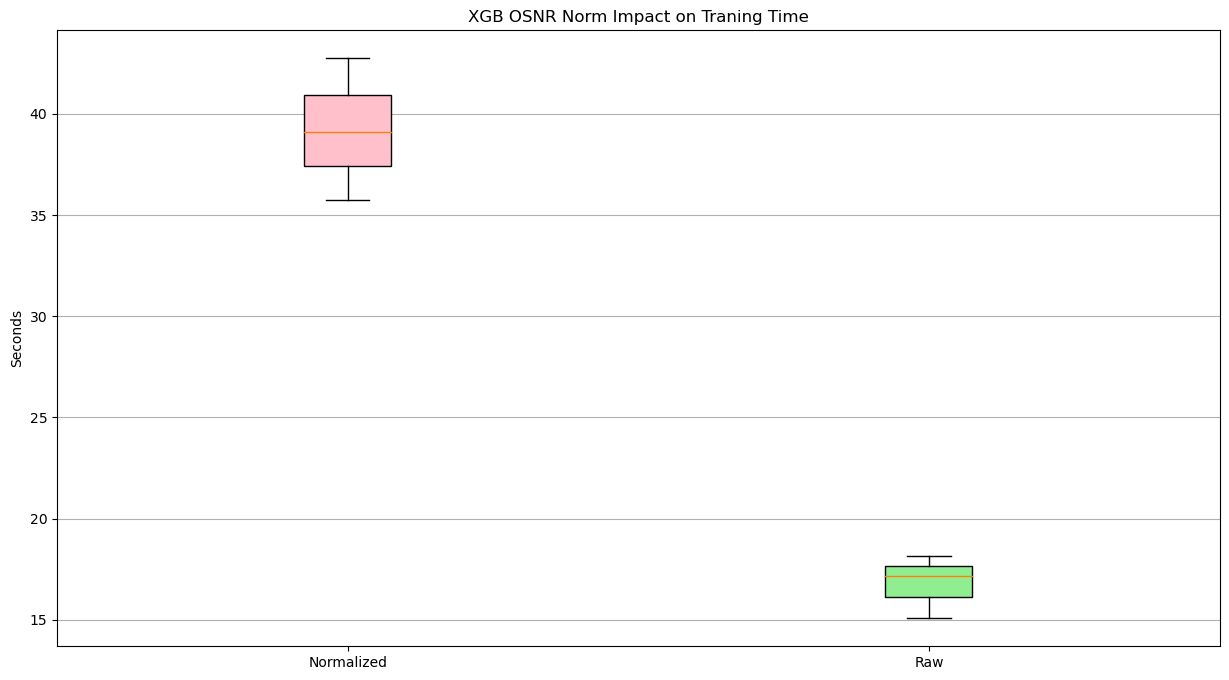

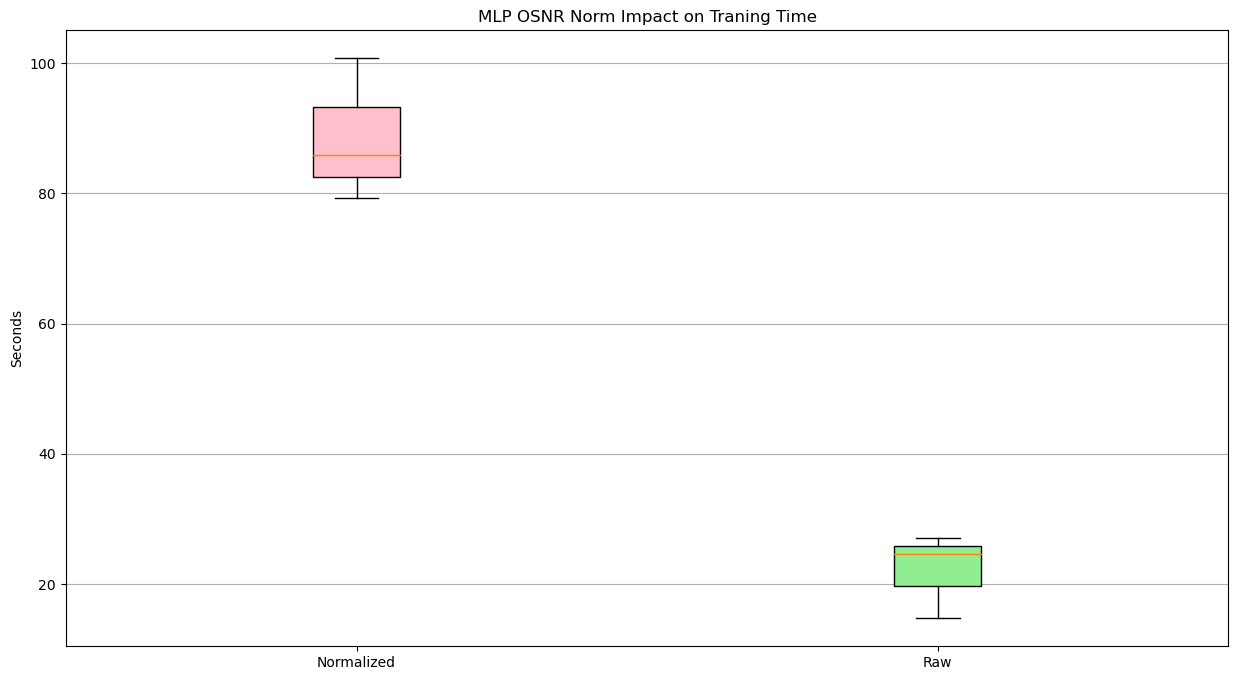

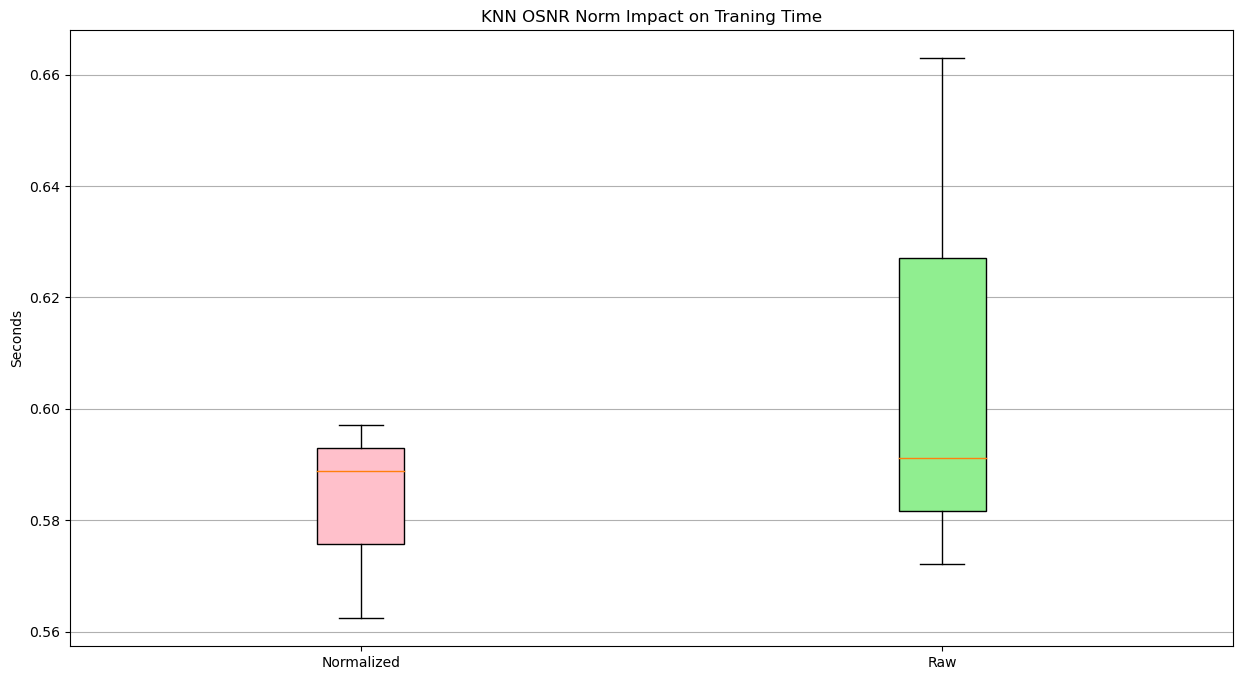

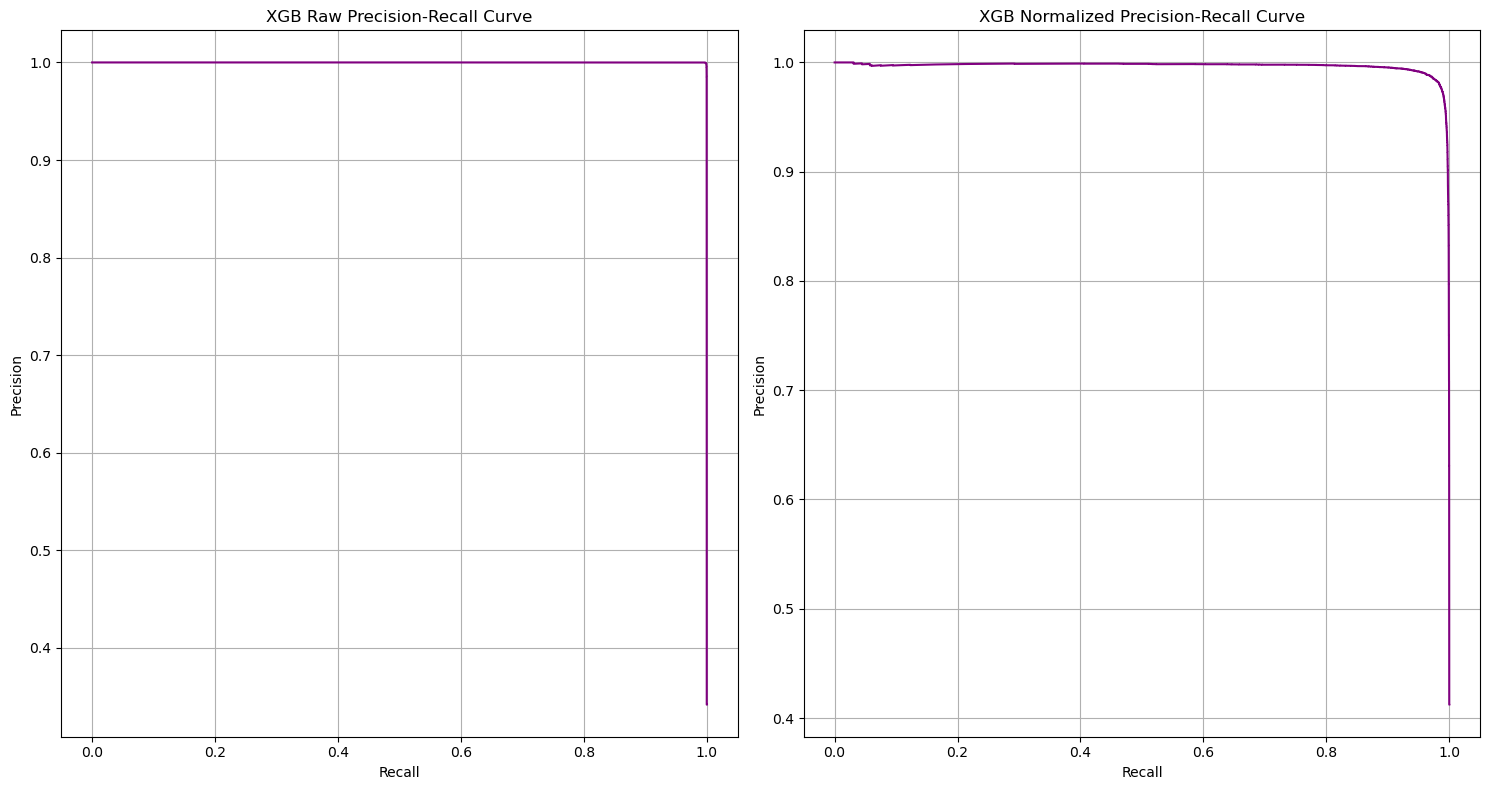

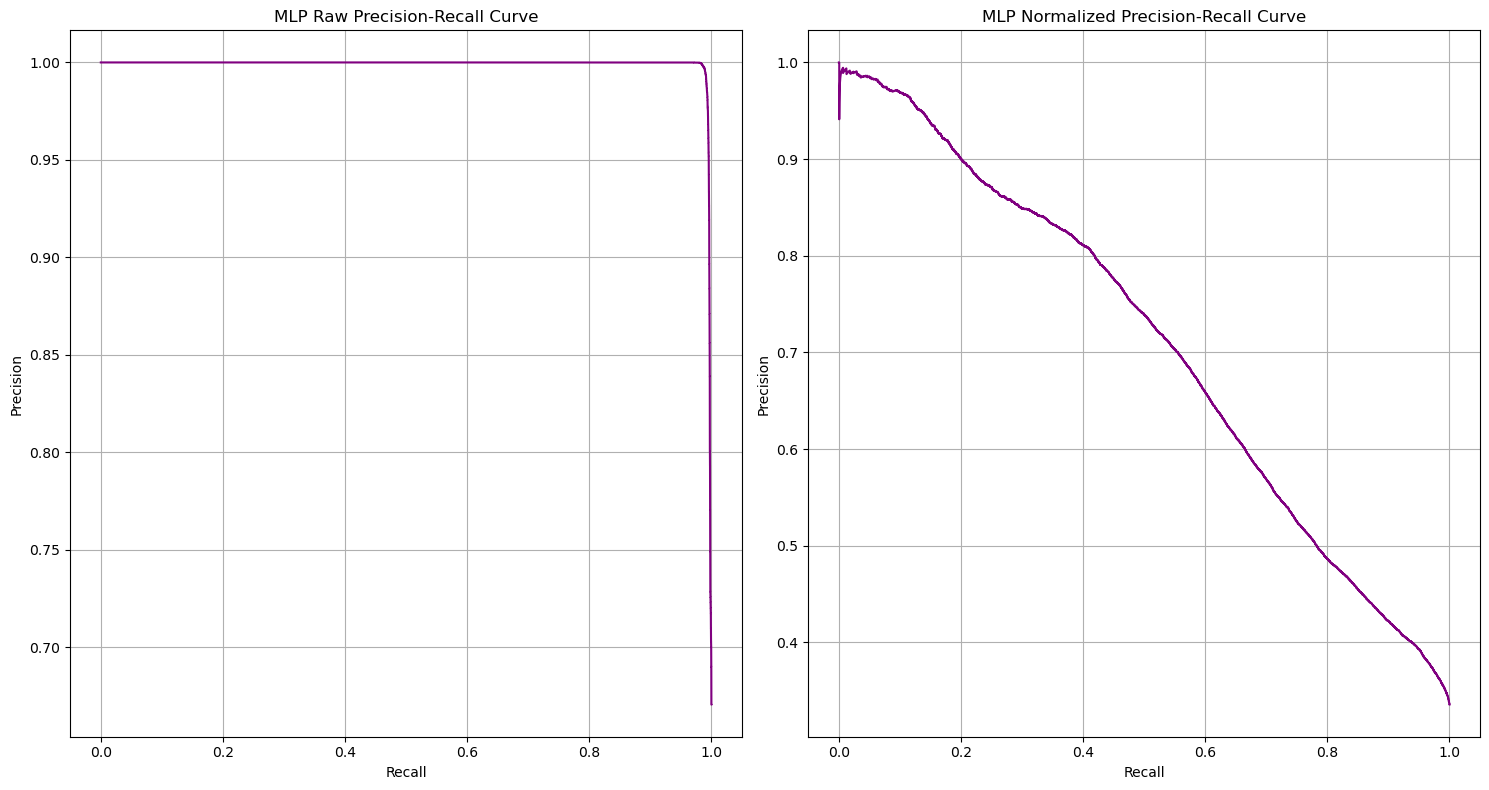

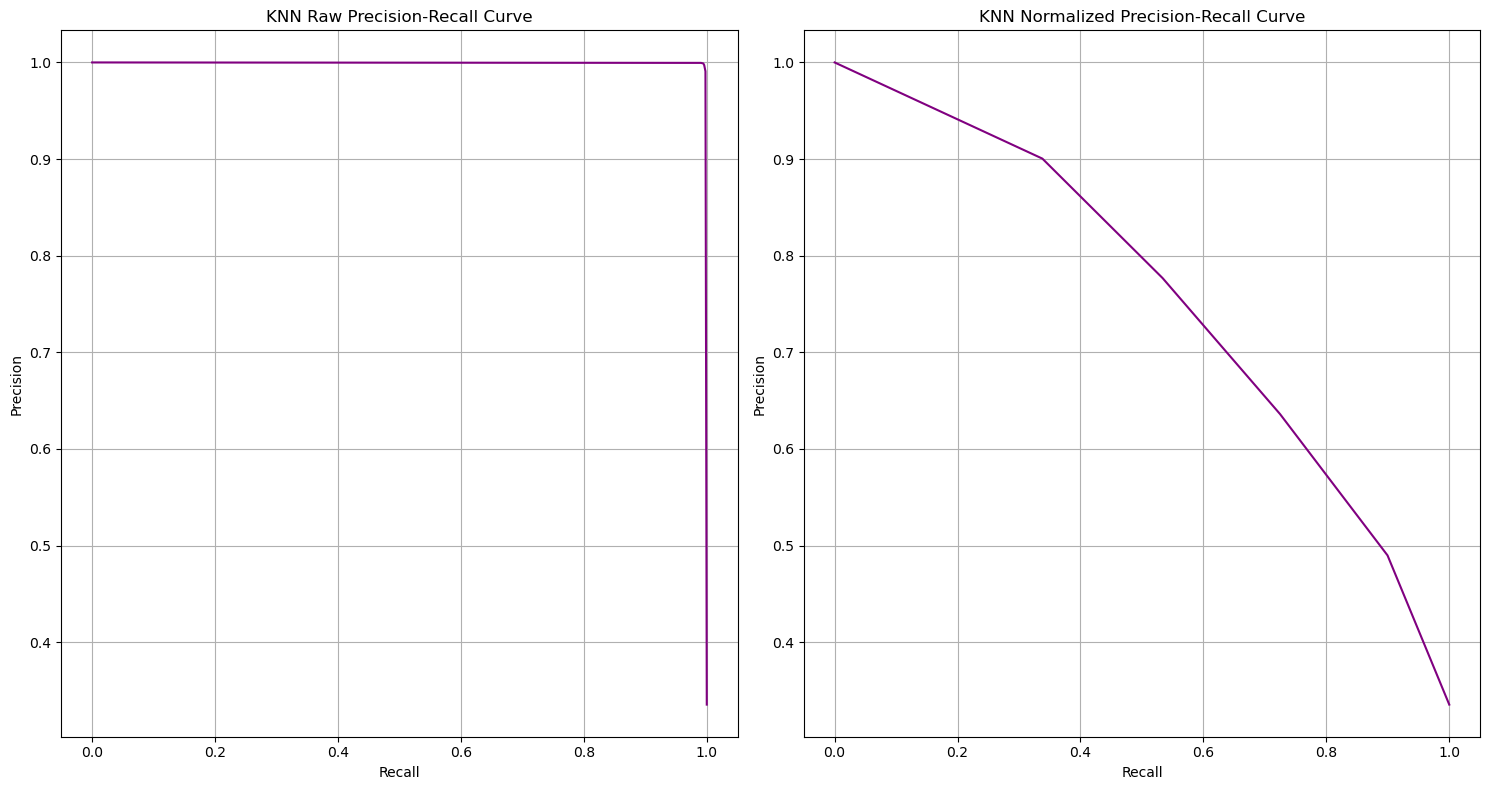

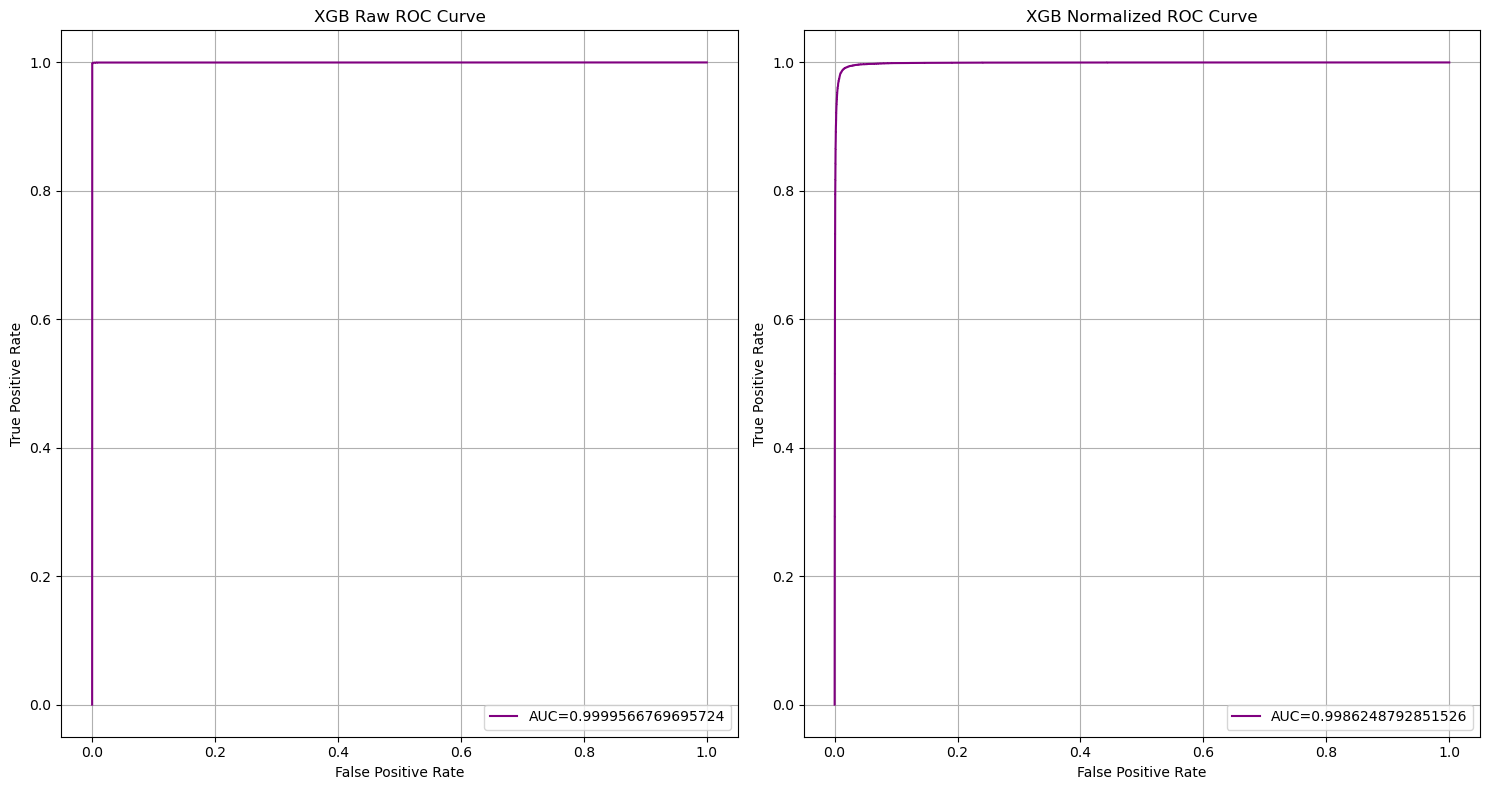

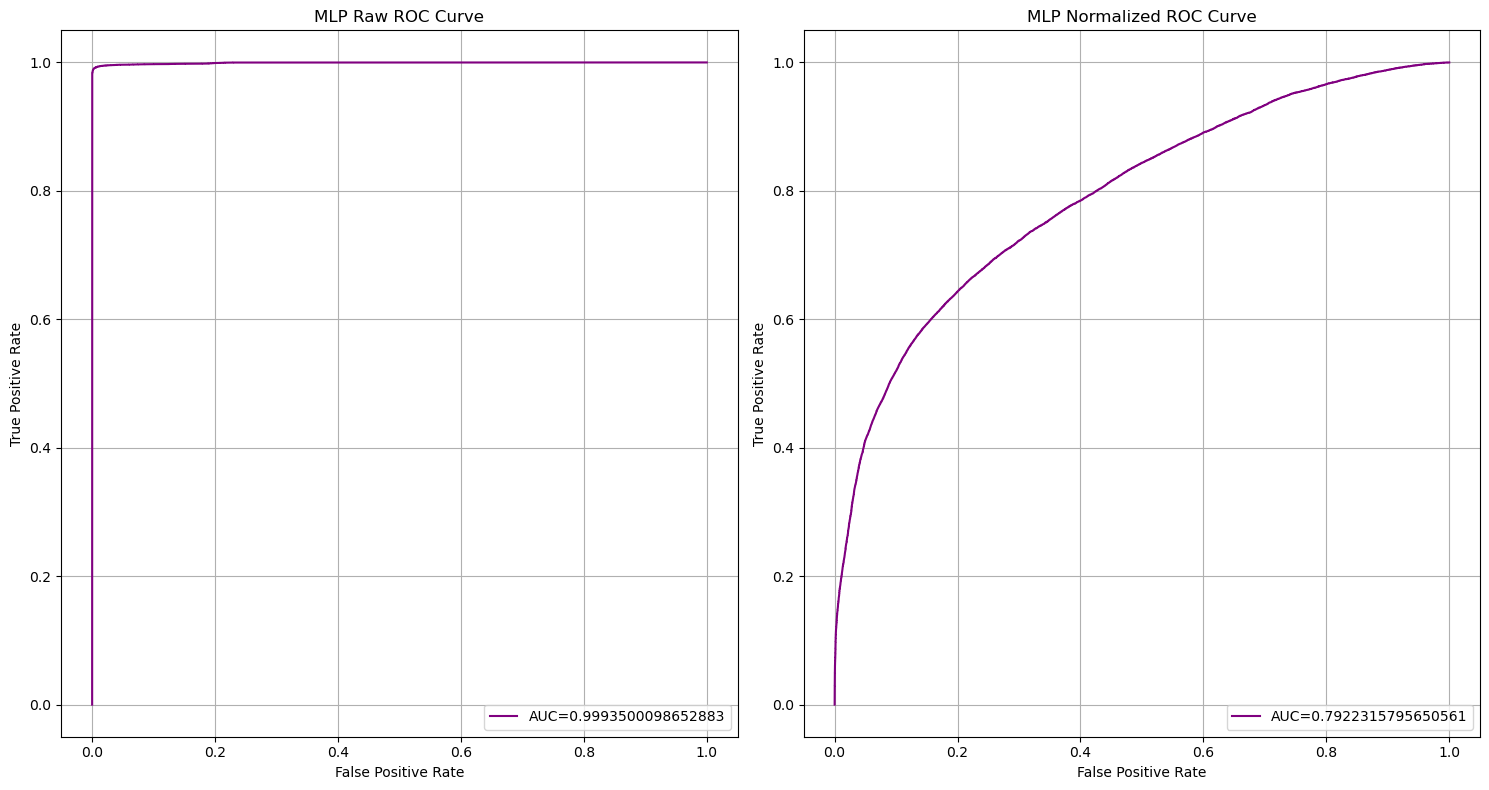

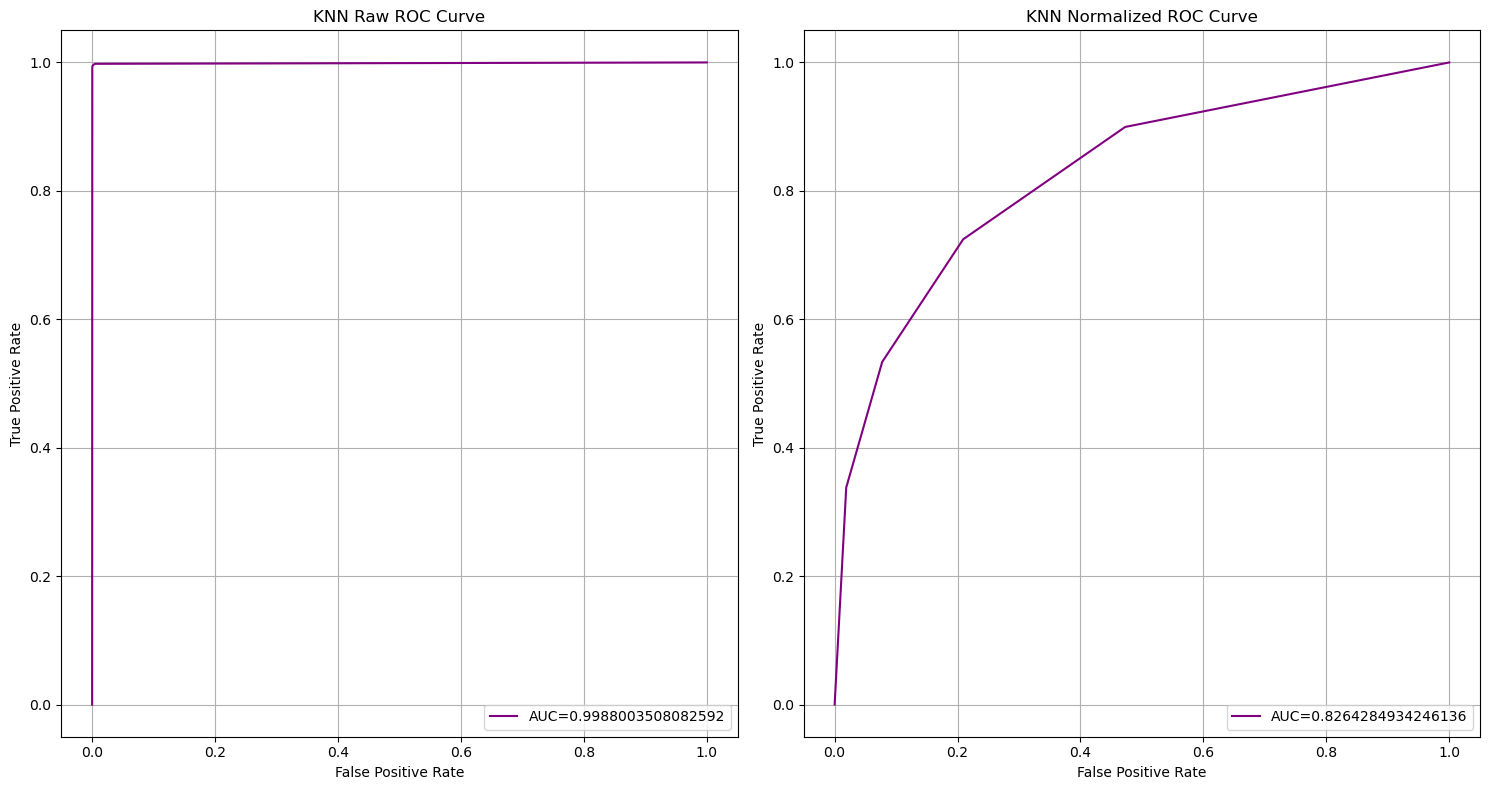

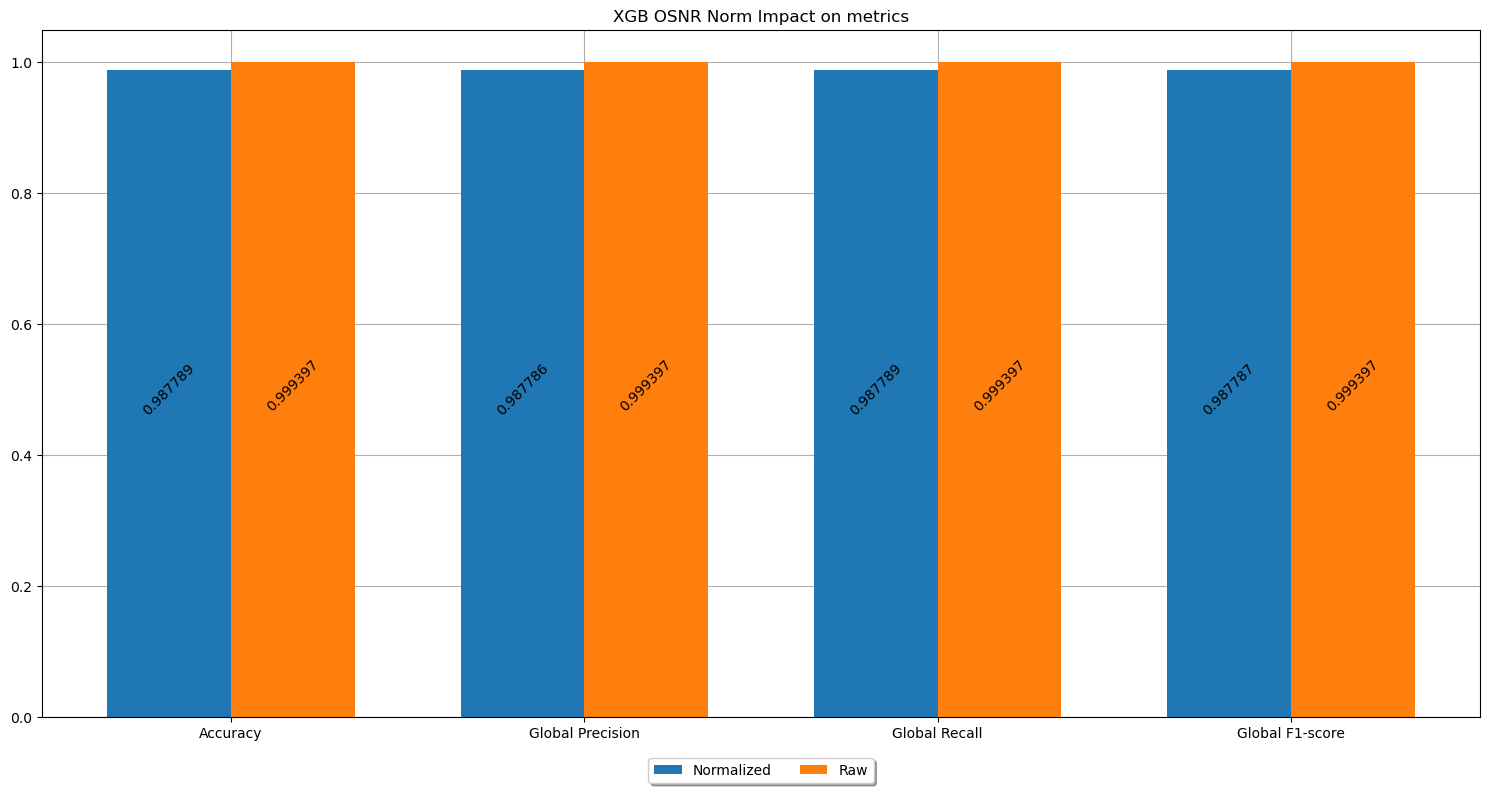

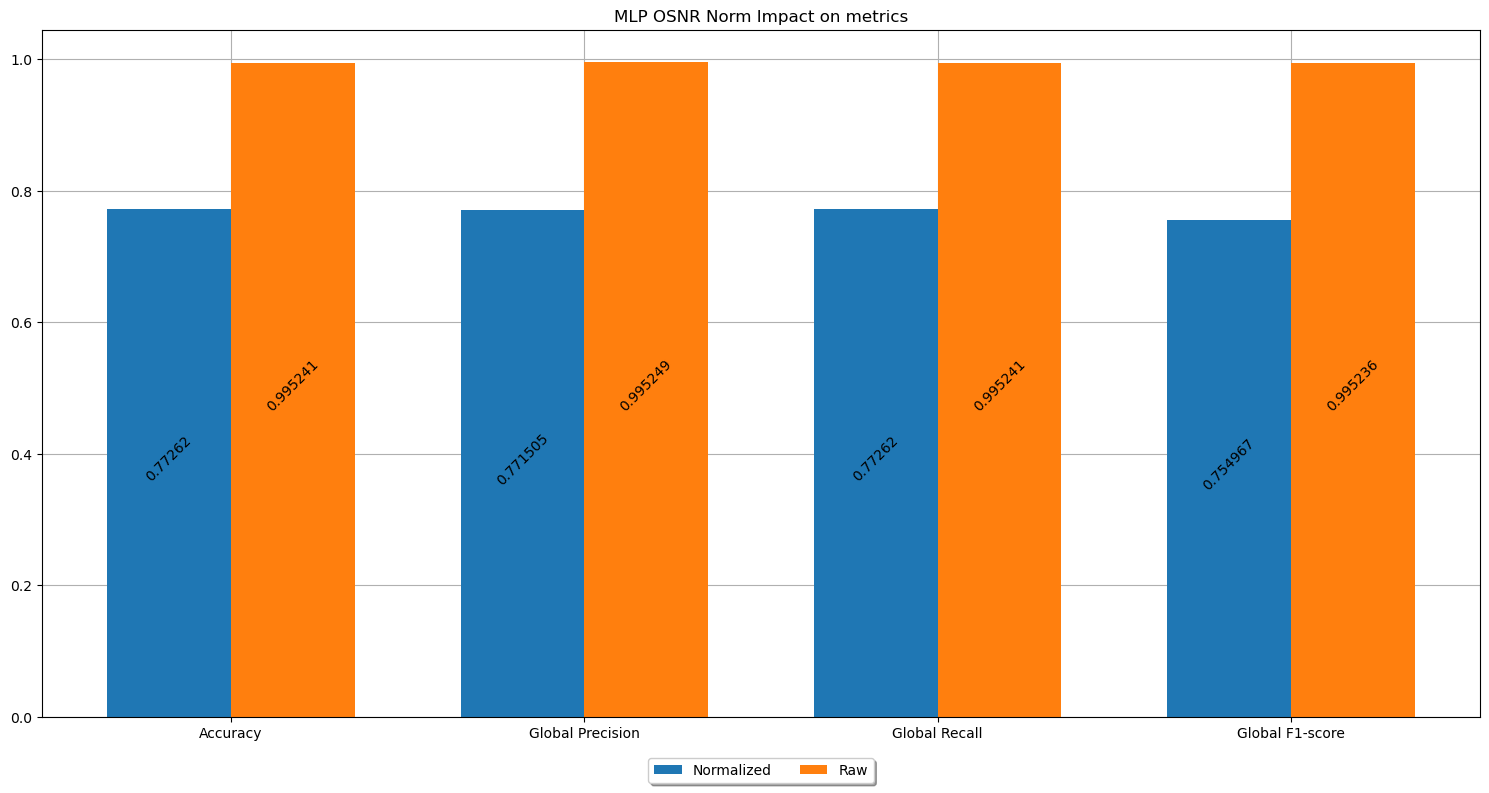

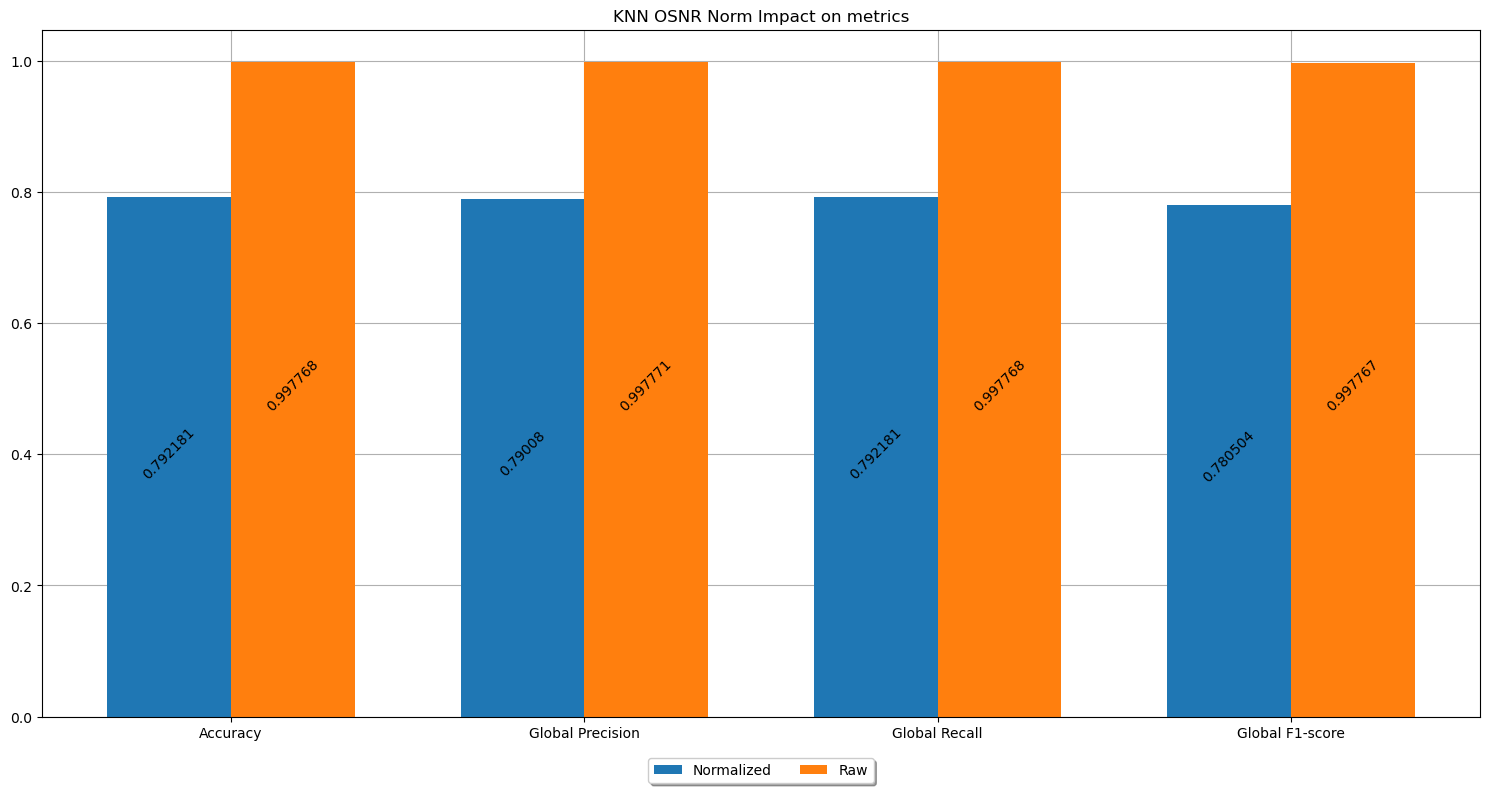

In [10]:
fig_folder = '1_9_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
        
# Candles for 'Traning Time'
candle_norm_impact(fig_folder, 'XGB', xgb_stats_norm[0], xgb_stats_raw[0])    
candle_norm_impact(fig_folder, 'MLP', dnn_stats_norm[0], dnn_stats_raw[0])
candle_norm_impact(fig_folder, 'KNN', knn_stats_norm[0], knn_stats_raw[0])

# PR curve
plot_precision_recall_curve(fig_folder, 'XGB', xgb_stats_raw[1], xgb_stats_raw[2], xgb_stats_norm[1], xgb_stats_norm[2])
plot_precision_recall_curve(fig_folder, 'MLP', dnn_stats_raw[1], dnn_stats_raw[2], dnn_stats_norm[1], dnn_stats_norm[2])
plot_precision_recall_curve(fig_folder, 'KNN', knn_stats_raw[1], knn_stats_raw[2], knn_stats_norm[1], knn_stats_norm[2])

# ROC curve
plot_roc_curve(fig_folder, 'XGB', xgb_stats_raw[3], xgb_stats_raw[4], xgb_stats_raw[5], xgb_stats_norm[3], xgb_stats_norm[4], xgb_stats_norm[5])
plot_roc_curve(fig_folder, 'MLP', dnn_stats_raw[3], dnn_stats_raw[4], dnn_stats_raw[5], dnn_stats_norm[3], dnn_stats_norm[4], dnn_stats_norm[5])
plot_roc_curve(fig_folder, 'KNN', knn_stats_raw[3], knn_stats_raw[4], knn_stats_raw[5], knn_stats_norm[3], knn_stats_norm[4], knn_stats_norm[5])

# Stats charts
stats_labels= ['Accuracy', 'Global Precision', 'Global Recall', 'Global F1-score']
bar_chart_norm_impact(fig_folder, 'XGB', stats_labels, xgb_stats_norm[6:], xgb_stats_raw[6:])    
bar_chart_norm_impact(fig_folder, 'MLP', stats_labels, dnn_stats_norm[6:], dnn_stats_raw[6:])
bar_chart_norm_impact(fig_folder, 'KNN', stats_labels, knn_stats_norm[6:], knn_stats_raw[6:])
